In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt        
import seaborn as sns  

from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

from sklearn.model_selection import StratifiedKFold, KFold,GroupKFold, RepeatedStratifiedKFold, RepeatedKFold
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN 

import xgboost as xgb

import optuna 
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

import warnings
warnings.filterwarnings("ignore")

from pandas_profiling import ProfileReport as profile

import pkg_resources as pkg
print( f"pandas_profiling version: {pkg.get_distribution('pandas_profiling').version}")

/kaggle/input/song-popularity-prediction/sample_submission.csv
/kaggle/input/song-popularity-prediction/train.csv
/kaggle/input/song-popularity-prediction/test.csv
pandas_profiling version: 3.0.0


In [341]:
train = pd.read_csv('/kaggle/input/song-popularity-prediction/train.csv')
test = pd.read_csv('/kaggle/input/song-popularity-prediction/test.csv')
submission = pd.read_csv('/kaggle/input/song-popularity-prediction/sample_submission.csv')

In [342]:
train.head(5)

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
0,0,212990.0,0.642286,0.856520,0.707073,0.002001,10.0,NaN,-5.619088,0,0.082570,158.386236,4,0.734642,0
1,1,NaN,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1
2,2,193213.0,NaN,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0,0.052282,178.685791,3,0.425536,0
3,3,249893.0,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0,0.035618,128.715630,3,0.453597,0
4,4,165969.0,0.493017,NaN,0.740982,0.002033,10.0,0.094891,-2.684095,0,0.050746,121.928157,4,0.741311,0


### Impute missing data

In [343]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
song_duration_ms,4101,0.102525
liveness,4086,0.102150
key,4065,0.101625
danceability,4026,0.100650
acousticness,3992,0.099800
instrumentalness,3985,0.099625
energy,3975,0.099375
loudness,3957,0.098925
id,0,0.000000
audio_mode,0,0.000000


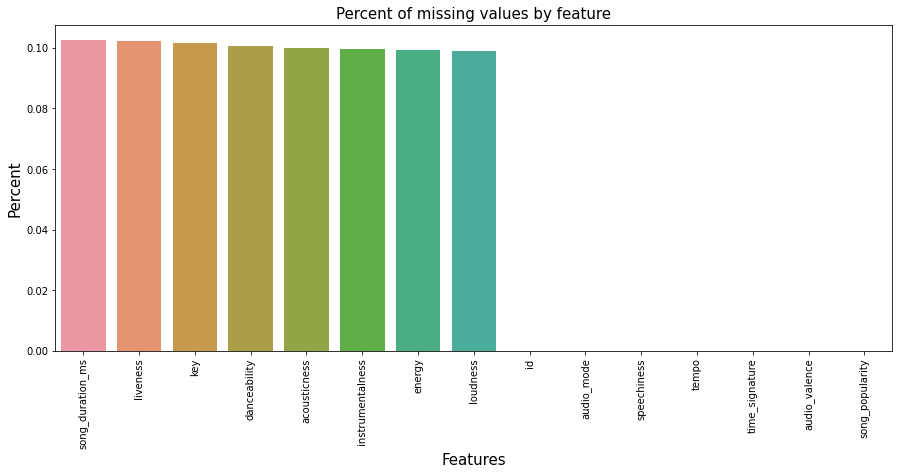

In [344]:
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent', fontsize=15)
plt.title('Percent of missing values by feature', fontsize=15)
plt.show()

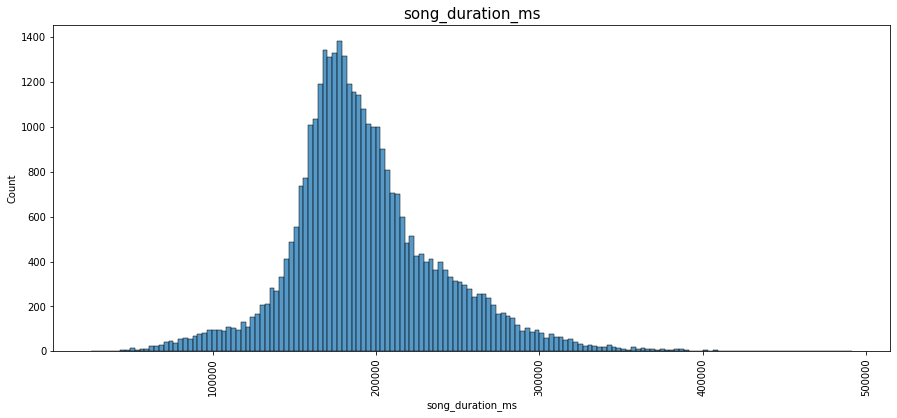

In [345]:
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.histplot(x=train.song_duration_ms)
plt.title('song_duration_ms', fontsize=15)
plt.show()

In [346]:
FEATURES = ['song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'audio_mode',
       'speechiness', 'tempo', 'time_signature', 'audio_valence']

imputer = IterativeImputer()
train[FEATURES] = imputer.fit_transform(train[FEATURES])
test[FEATURES] = imputer.transform(test[FEATURES])

In [347]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
id,0,0.0
song_duration_ms,0,0.0
acousticness,0,0.0
danceability,0,0.0
energy,0,0.0
instrumentalness,0,0.0
key,0,0.0
liveness,0,0.0
loudness,0,0.0
audio_mode,0,0.0


### Balance target

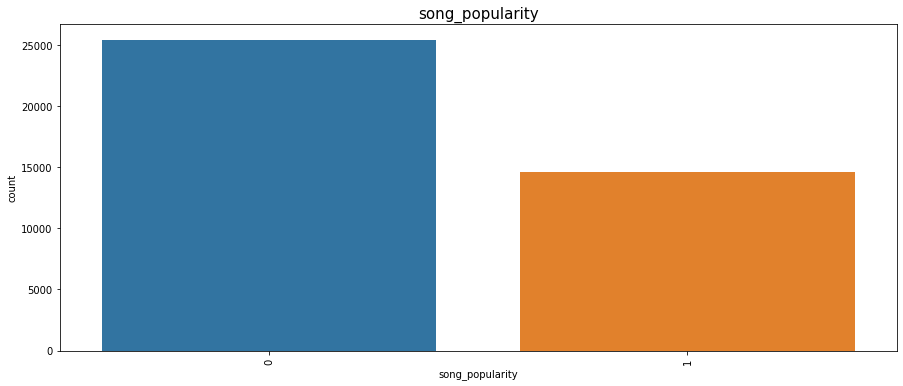

In [348]:
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.countplot(x=train.song_popularity)
plt.title('song_popularity', fontsize=15)
plt.show()

In [349]:
FEATURE_COLUMNS = [ 'key', 'audio_mode', 'time_signature']
CAT_FEATURES = []

def add_cross_features(df):
    for feature1 in FEATURE_COLUMNS:    
        for feature2 in FEATURE_COLUMNS:
            if feature1 != feature2:
                x2_feature_name = f'{feature1}-{feature2}'
                x2_feature_name_2 = f'{feature2}-{feature1}'
                if x2_feature_name not in df.columns and x2_feature_name_2 not in df.columns:
                    df[x2_feature_name] = df[feature1].astype(str) + '_' + df[feature2].astype(str)
                    CAT_FEATURES.append(x2_feature_name)
    return df
                
train = add_cross_features(train)
test = add_cross_features(test)

ALL_FEATURES = FEATURES
for f in CAT_FEATURES:
    if f not in ALL_FEATURES:
        ALL_FEATURES.append(f)
    
print(len(ALL_FEATURES))

16


In [350]:
def encode_cat_feature( df, test_df, feature_name):
    print(feature_name)
    all_values = np.concatenate( (df[feature_name].values, test_df[feature_name].values))    
    encoder = LabelEncoder()
    encoder.fit(all_values)
    df[feature_name] = encoder.transform(df[feature_name])
    test_df[feature_name] = encoder.transform(test_df[feature_name])
    return df, test_df

CAT_FEATURES.append('audio_mode')
CAT_FEATURES.append('key')
CAT_FEATURES.append('time_signature')

for cat in CAT_FEATURES:
    train, test = encode_cat_feature(train, test, cat)
    
#train.drop(['audio_mode', 'key', 'time_signature'], axis=1, inplace=True) 
#test.drop(['audio_mode', 'key', 'time_signature'], axis=1, inplace=True) 
ALL_FEATURES

key-audio_mode
key-time_signature
audio_mode-time_signature
key-audio_mode
key-time_signature
audio_mode-time_signature
audio_mode
key
time_signature


['song_duration_ms',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'audio_mode',
 'speechiness',
 'tempo',
 'time_signature',
 'audio_valence',
 'key-audio_mode',
 'key-time_signature',
 'audio_mode-time_signature']

In [351]:
RANDOM_SEED = 42

sampler = RandomOverSampler()
X_over, y_over = sampler.fit_resample(train, train.song_popularity)

sampler = RandomUnderSampler()
X_under, y_under = sampler.fit_resample(train, train.song_popularity)

sampler = SMOTEENN(random_state=RANDOM_SEED)
X_sme, y_sme = sampler.fit_resample(train, train.song_popularity)

In [352]:
train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)


USE_UNDER_SAMPLER = False
USE_OVER_SAMPLER = False
USE_SMOTEENN_SAMPLER = False

if USE_UNDER_SAMPLER:
    target = y_under.astype(int)
    train = X_under
elif USE_OVER_SAMPLER:
    target = y_over.astype(int)
    train = X_over
elif USE_SMOTEENN_SAMPLER:
    target = y_sme.astype(int)
    train = X_sme
else:
    target = train.song_popularity.astype(int)


train.drop(['song_popularity'], axis=1, inplace=True)

## HIGH CORR
#train.drop(['acousticness', 'loudness'], axis=1, inplace=True) 
#test.drop(['acousticness', 'loudness'], axis=1, inplace=True) 

In [353]:
#train_profile = profile(train, title="Train Data", minimal=False)
#display(train_profile)

In [354]:
#test_profile = profile(test, title="Test Data", minimal=False)
#display(test_profile)

### Scale data

In [355]:
test

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,key-audio_mode,key-time_signature,audio_mode-time_signature
0,308523.000000,0.019845,0.435638,0.908939,0.001438,2612,0.112832,-8.890172,0,0.082714,126.129304,2,0.399620,2622,2636,2
1,200011.000000,0.070119,0.731256,0.444655,0.002020,5067,0.139040,-6.301214,0,0.061685,86.448149,1,0.499424,6,11,1
2,279758.000000,0.810637,0.568858,0.125466,0.898841,0,0.226614,-11.542478,0,0.041868,99.544351,1,0.564951,0,1,1
3,249197.000000,0.310952,0.871789,0.557342,0.000715,683,0.325391,-7.905546,1,0.046815,123.063854,2,0.906485,772,783,6
4,178304.230615,0.765568,0.624687,0.710794,0.000346,5065,0.308284,-7.886946,0,0.129284,88.703121,1,0.935571,5077,5096,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,196204.000000,0.083936,0.823252,0.442246,0.002990,1,0.123921,-8.682195,1,0.041171,98.264618,2,0.784104,3,6,6
9996,218343.000000,0.105279,0.683743,0.848627,0.001911,4511,0.106522,-4.946250,0,0.033605,103.949646,2,0.850754,4687,4703,2
9997,188434.000000,0.753472,0.783947,0.498261,0.134027,4511,0.088147,-11.812606,1,0.029526,119.090558,2,0.482961,4688,4703,6
9998,173044.000000,0.863579,0.373283,0.476142,0.000049,5067,0.122122,-12.371232,0,0.190628,103.048349,1,0.518742,6,11,1


In [357]:
def scale_feature( df, test_df, feature_name):
    print(feature_name)
    all_values = np.concatenate( (df[feature_name].values, test_df[feature_name].values)).reshape(-1, 1)
    scaler = RobustScaler()
    scaler.fit(all_values)
    df[feature_name] = scaler.transform(df[feature_name].values.reshape(-1, 1))
    test_df[feature_name] = scaler.transform(test_df[feature_name].values.reshape(-1, 1))
    return df, test_df

SCALE_FEATURES = ['song_duration_ms', 'key-audio_mode', 'key-time_signature', 'audio_mode-time_signature']

train_scaled = train
test_scaled = test
for cat in SCALE_FEATURES:
    train_scaled, test_scaled = scale_feature(train_scaled, test_scaled, cat)

song_duration_ms
key-audio_mode
key-time_signature
audio_mode-time_signature


In [358]:
#scaler = RobustScaler()

#train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)
#test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns)

#train_scaled = train
#test_scaled = test

In [361]:
print( train_scaled.shape) 
print( test_scaled.shape) 

(40000, 16)
(10000, 16)


## Tune

In [362]:
NUM_BOOST_ROUND = 600
EARLY_STOPPING_ROUNDS = 200
VERBOSE_EVAL = 100
RANDOM_SEED = 42
TUNING = False
N_TRIALS = 25

    
def objective(trial, X, y):
    
    scale_pos_weight = sum(y==0)/sum(y==1)
    
    param_grid = {
        'verbosity': 1,
        'objective': 'binary:logistic', 
        'eval_metric' : 'auc',
        'n_estimators' : NUM_BOOST_ROUND,
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.01),
        'eta': trial.suggest_float('eta', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 50, 500),     
        'min_child_weight': trial.suggest_float('min_child_weight', 50, 250),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.9),
        'gamma': trial.suggest_float('gamma', 0, 100),
        'subsample': trial.suggest_float('subsample', 0.1, 0.9),
        'lambda': trial.suggest_float('lambda', 1, 10),
        'alpha': trial.suggest_float('alpha', 0, 9),
        'scale_pos_weight': scale_pos_weight,
    }    
        
    X_train, X_valid, y_train, y_valid = train_test_split( X, y, test_size=0.25, 
                                                          random_state=RANDOM_SEED, shuffle=True)
    
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dvalid = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)
        
    model = xgb.XGBClassifier( use_label_encoder=True, **param_grid)  
    model.fit( X_train.values, y_train.values,
            eval_set = [ (X_train.values, y_train.values), (X_valid.values, y_valid.values) ],
            callbacks = [xgb.callback.EarlyStopping(rounds=EARLY_STOPPING_ROUNDS, save_best=True)],
            verbose=False)    
    
    oof_pred = model.predict(X_valid)
    score = f1_score(y_valid, oof_pred)
    oof_auc_score = roc_auc_score(y_valid, oof_pred)
    print(f'OOF F1 score: {score}, AUC score: {oof_auc_score}')
    
    return oof_auc_score

if TUNING:
    study = optuna.create_study(direction='maximize')
    objective_func = lambda trial: objective(trial, train_scaled, target)
    study.optimize(objective_func, n_trials=N_TRIALS)  

    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

In [363]:
TOTAL_SPLITS = 2
N_REPEATS = 2
NUM_BOOST_ROUND = 1000
EARLY_STOPPING_ROUNDS = 100
VERBOSE_EVAL = 200

def run_train(X, y, run_params, splits, num_boost_round, verbose_eval, early_stopping_rounds ):
    models = []
    scores = []
    eval_results = {}  # to record eval results for plotting
    #folds = RepeatedStratifiedKFold(n_splits=splits, n_repeats=N_REPEATS, random_state=RANDOM_SEED)
    folds = StratifiedKFold(n_splits=splits, random_state=RANDOM_SEED)
        
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print(f'Fold {fold_n+1} started')
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
        dvalid = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)
        model = xgb.train( run_params, dtrain,
            num_boost_round = num_boost_round,
            evals=[(dvalid, 'evals')], 
            verbose_eval = verbose_eval,
            early_stopping_rounds=early_stopping_rounds
        )   

        scores.append(model.best_score)
        models.append(model)
    return models, eval_results, scores

scale_pos_weight = sum(target==0)/sum(target==1)

under_params = {
    'verbosity': 1,
    'objective': 'binary:logistic', 
    'eval_metric': ['logloss','auc'],
    'learning_rate': 0.176722404455782796,
    'eta': 0.9764414987043088,
    'max_depth': 200,
    'min_child_weight': 80,
    'colsample_bytree': 0.8,
    'gamma': 2.2,
    'subsample': 0.95,
    'lambda': 2.54,
    'alpha': 0.8,
}

run_params = {
    'verbosity': 1,
    'objective': 'binary:logistic', 
    'eval_metric': ['logloss','auc'],
    'learning_rate': 0.1974105129432222,
    'eta': 0.29151787034760856,
    'scale_pos_weight': scale_pos_weight,
}

models, eval_results, scores = run_train(train_scaled, target, under_params, 
                                         TOTAL_SPLITS, NUM_BOOST_ROUND, VERBOSE_EVAL, EARLY_STOPPING_ROUNDS)

Fold 1 started
[0]	evals-logloss:0.68045	evals-auc:0.53447
[122]	evals-logloss:0.66899	evals-auc:0.55008
Fold 2 started
[0]	evals-logloss:0.68022	evals-auc:0.54124
[112]	evals-logloss:0.66814	evals-auc:0.54913


### Validation

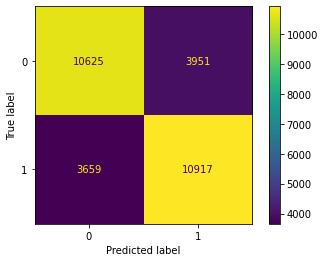

In [102]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = np.zeros( (len(models), len(train_scaled)) )
for i in range(len(models)):
    y_pred[i] = models[i].predict(xgb.DMatrix(train_scaled, enable_categorical=True))

y_pred = np.mean(y_pred, axis=0)
y_predicted = np.where(y_pred > 0.5, 1, 0)

cm = confusion_matrix(target, y_predicted)
cm_display = ConfusionMatrixDisplay(cm).plot()

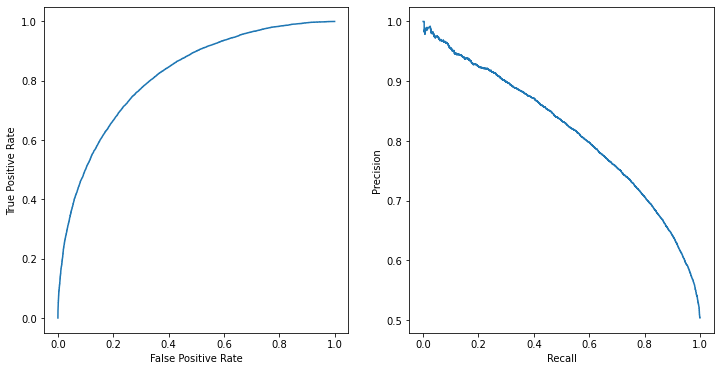

In [103]:
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

fpr, tpr, _ = roc_curve(target, y_pred)
prec, recall, _ = precision_recall_curve(target, y_pred)

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax1)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax2)

### Submission

In [ ]:
y_pred = np.zeros( (len(models), len(test)) )
for i in range(len(models)):
    y_pred[i] = models[i].predict(xgb.DMatrix(test, enable_categorical=True))

y_pred = np.mean(y_pred, axis=0)
y_predicted = np.where(y_pred > 0.5, 1, 0)

In [ ]:
# more like a sanity check

f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.countplot(x=y_predicted)
plt.show()

In [ ]:
submission['song_popularity'] = y_predicted
submission.to_csv('submission.csv', index=False, float_format='%.6f')
submission.head(20)